In [1]:
from pyomo.environ import *
import numpy as np
import qiskit
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.primitives import Sampler
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize
from qiskit.visualization import plot_distribution
import warnings
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
mu = [20, 40, 20, 15, 30] # Expected returns from each project
alpha = 1 # Penalty 
n = len(mu) # Number of projects

cov_matrix = np.zeros((n, n))

print(cov_matrix)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
projectSelectionQP = QuadraticProgram("Project Selection")

print(projectSelectionQP.prettyprint())

Problem name: Project Selection

Minimize
  0

Subject to
  No constraints

  No variables



In [5]:
for i in range(n):
    projectSelectionQP.binary_var(name=f'x{i}')

In [6]:
linear = [-mu[i] for i in range(n)]
linear

[-20, -40, -20, -15, -30]

In [7]:
quadratic = {(f'x{i}', f'x{j}'): 0 for i in range(n) for j in range(i, n)}
quadratic

{('x0', 'x0'): 0,
 ('x0', 'x1'): 0,
 ('x0', 'x2'): 0,
 ('x0', 'x3'): 0,
 ('x0', 'x4'): 0,
 ('x1', 'x1'): 0,
 ('x1', 'x2'): 0,
 ('x1', 'x3'): 0,
 ('x1', 'x4'): 0,
 ('x2', 'x2'): 0,
 ('x2', 'x3'): 0,
 ('x2', 'x4'): 0,
 ('x3', 'x3'): 0,
 ('x3', 'x4'): 0,
 ('x4', 'x4'): 0}

In [8]:
projectSelectionQP.minimize(constant=0, linear=dict(zip([f'x{i}' for i in range(n)], linear)), quadratic=quadratic)

projectSelectionQP.linear_constraint(
    linear={'x0': 5, 'x1': 4, 'x2': 3, 'x3': 7, 'x4': 8},
    sense='<=',
    rhs=25
)

projectSelectionQP.linear_constraint(
    linear={'x0': 5, 'x1': 7, 'x2': 9, 'x3': 4, 'x4': 6},
    sense='<=',
    rhs=25
)

projectSelectionQP.linear_constraint(
    linear={'x0': 8, 'x1': 10, 'x2': 2, 'x3': 3, 'x4': 10},
    sense='<=',
    rhs=25
)

print(projectSelectionQP.prettyprint())

Problem name: Project Selection

Minimize
  -20*x0 - 40*x1 - 20*x2 - 15*x3 - 30*x4

Subject to
  Linear constraints (3)
    5*x0 + 4*x1 + 3*x2 + 7*x3 + 8*x4 <= 25  'c0'
    5*x0 + 7*x1 + 9*x2 + 4*x3 + 6*x4 <= 25  'c1'
    8*x0 + 10*x1 + 2*x2 + 3*x3 + 10*x4 <= 25  'c2'

  Binary variables (5)
    x0 x1 x2 x3 x4



In [9]:
exact_mes = NumPyMinimumEigensolver()
exact_optimizer = MinimumEigenOptimizer(exact_mes)
exact_result = exact_optimizer.solve(projectSelectionQP)

print(exact_result.prettyprint())

objective function value: -95.0
variable values: x0=1.0, x1=1.0, x2=1.0, x3=1.0, x4=0.0
status: SUCCESS


### Hamiltonian and QAOA circuit

In [10]:
constraints = [
    [5, 4, 3, 7, 8],  # restriction 1
    [5, 7, 9, 4, 6],  # restriction 2
    [8, 10, 2, 3, 10],  # restriction 3
]

rhs = [25, 25, 25]

In [11]:
projectSelectionQP = QuadraticProgram("Project Selection")

for i in range(n):
    projectSelectionQP.binary_var(name=f'x{i}')

linear = [-mu[i] for i in range(n)]
projectSelectionQP.minimize(linear=dict(zip([f'x{i}' for i in range(n)], linear)))

In [12]:
for k, (constraint, limit) in enumerate(zip(constraints, rhs)):

    penalty = {f'x{i}': coef for i, coef in enumerate(constraint)}
    

    projectSelectionQP.minimize(
        quadratic={(f'x{i}', f'x{j}'): alpha * penalty[f'x{i}'] * penalty[f'x{j}']
                   for i in range(n) for j in range(n)},
        linear={f'x{i}': -2 * alpha * limit * penalty[f'x{i}'] for i in range(n)},
        constant=alpha * limit**2
    )

In [13]:
qubo = QuadraticProgramToQubo().convert(projectSelectionQP)

print(qubo.prettyprint())

Problem name: Project Selection

Minimize
  64*x0^2 + 160*x0*x1 + 32*x0*x2 + 48*x0*x3 + 160*x0*x4 + 100*x1^2 + 40*x1*x2
  + 60*x1*x3 + 200*x1*x4 + 4*x2^2 + 12*x2*x3 + 40*x2*x4 + 9*x3^2 + 60*x3*x4
  + 100*x4^2 - 400*x0 - 500*x1 - 100*x2 - 150*x3 - 500*x4 + 625

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



In [14]:
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

In [15]:
hamiltonian, offset = qubo.to_ising()

print("Hamiltonian:", hamiltonian)
print("\nOffset:", offset)

Hamiltonian: SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII', 'ZIZII', 'ZZIII'],
              coeffs=[68. +0.j, 85. +0.j, 17. +0.j, 25.5+0.j, 85. +0.j, 40. +0.j,  8. +0.j,
 12. +0.j, 40. +0.j, 10. +0.j, 15. +0.j, 50. +0.j,  3. +0.j, 10. +0.j,
 15. +0.j])

Offset: 141.5


In [16]:
ansatz = QAOAAnsatz(hamiltonian, reps=6)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

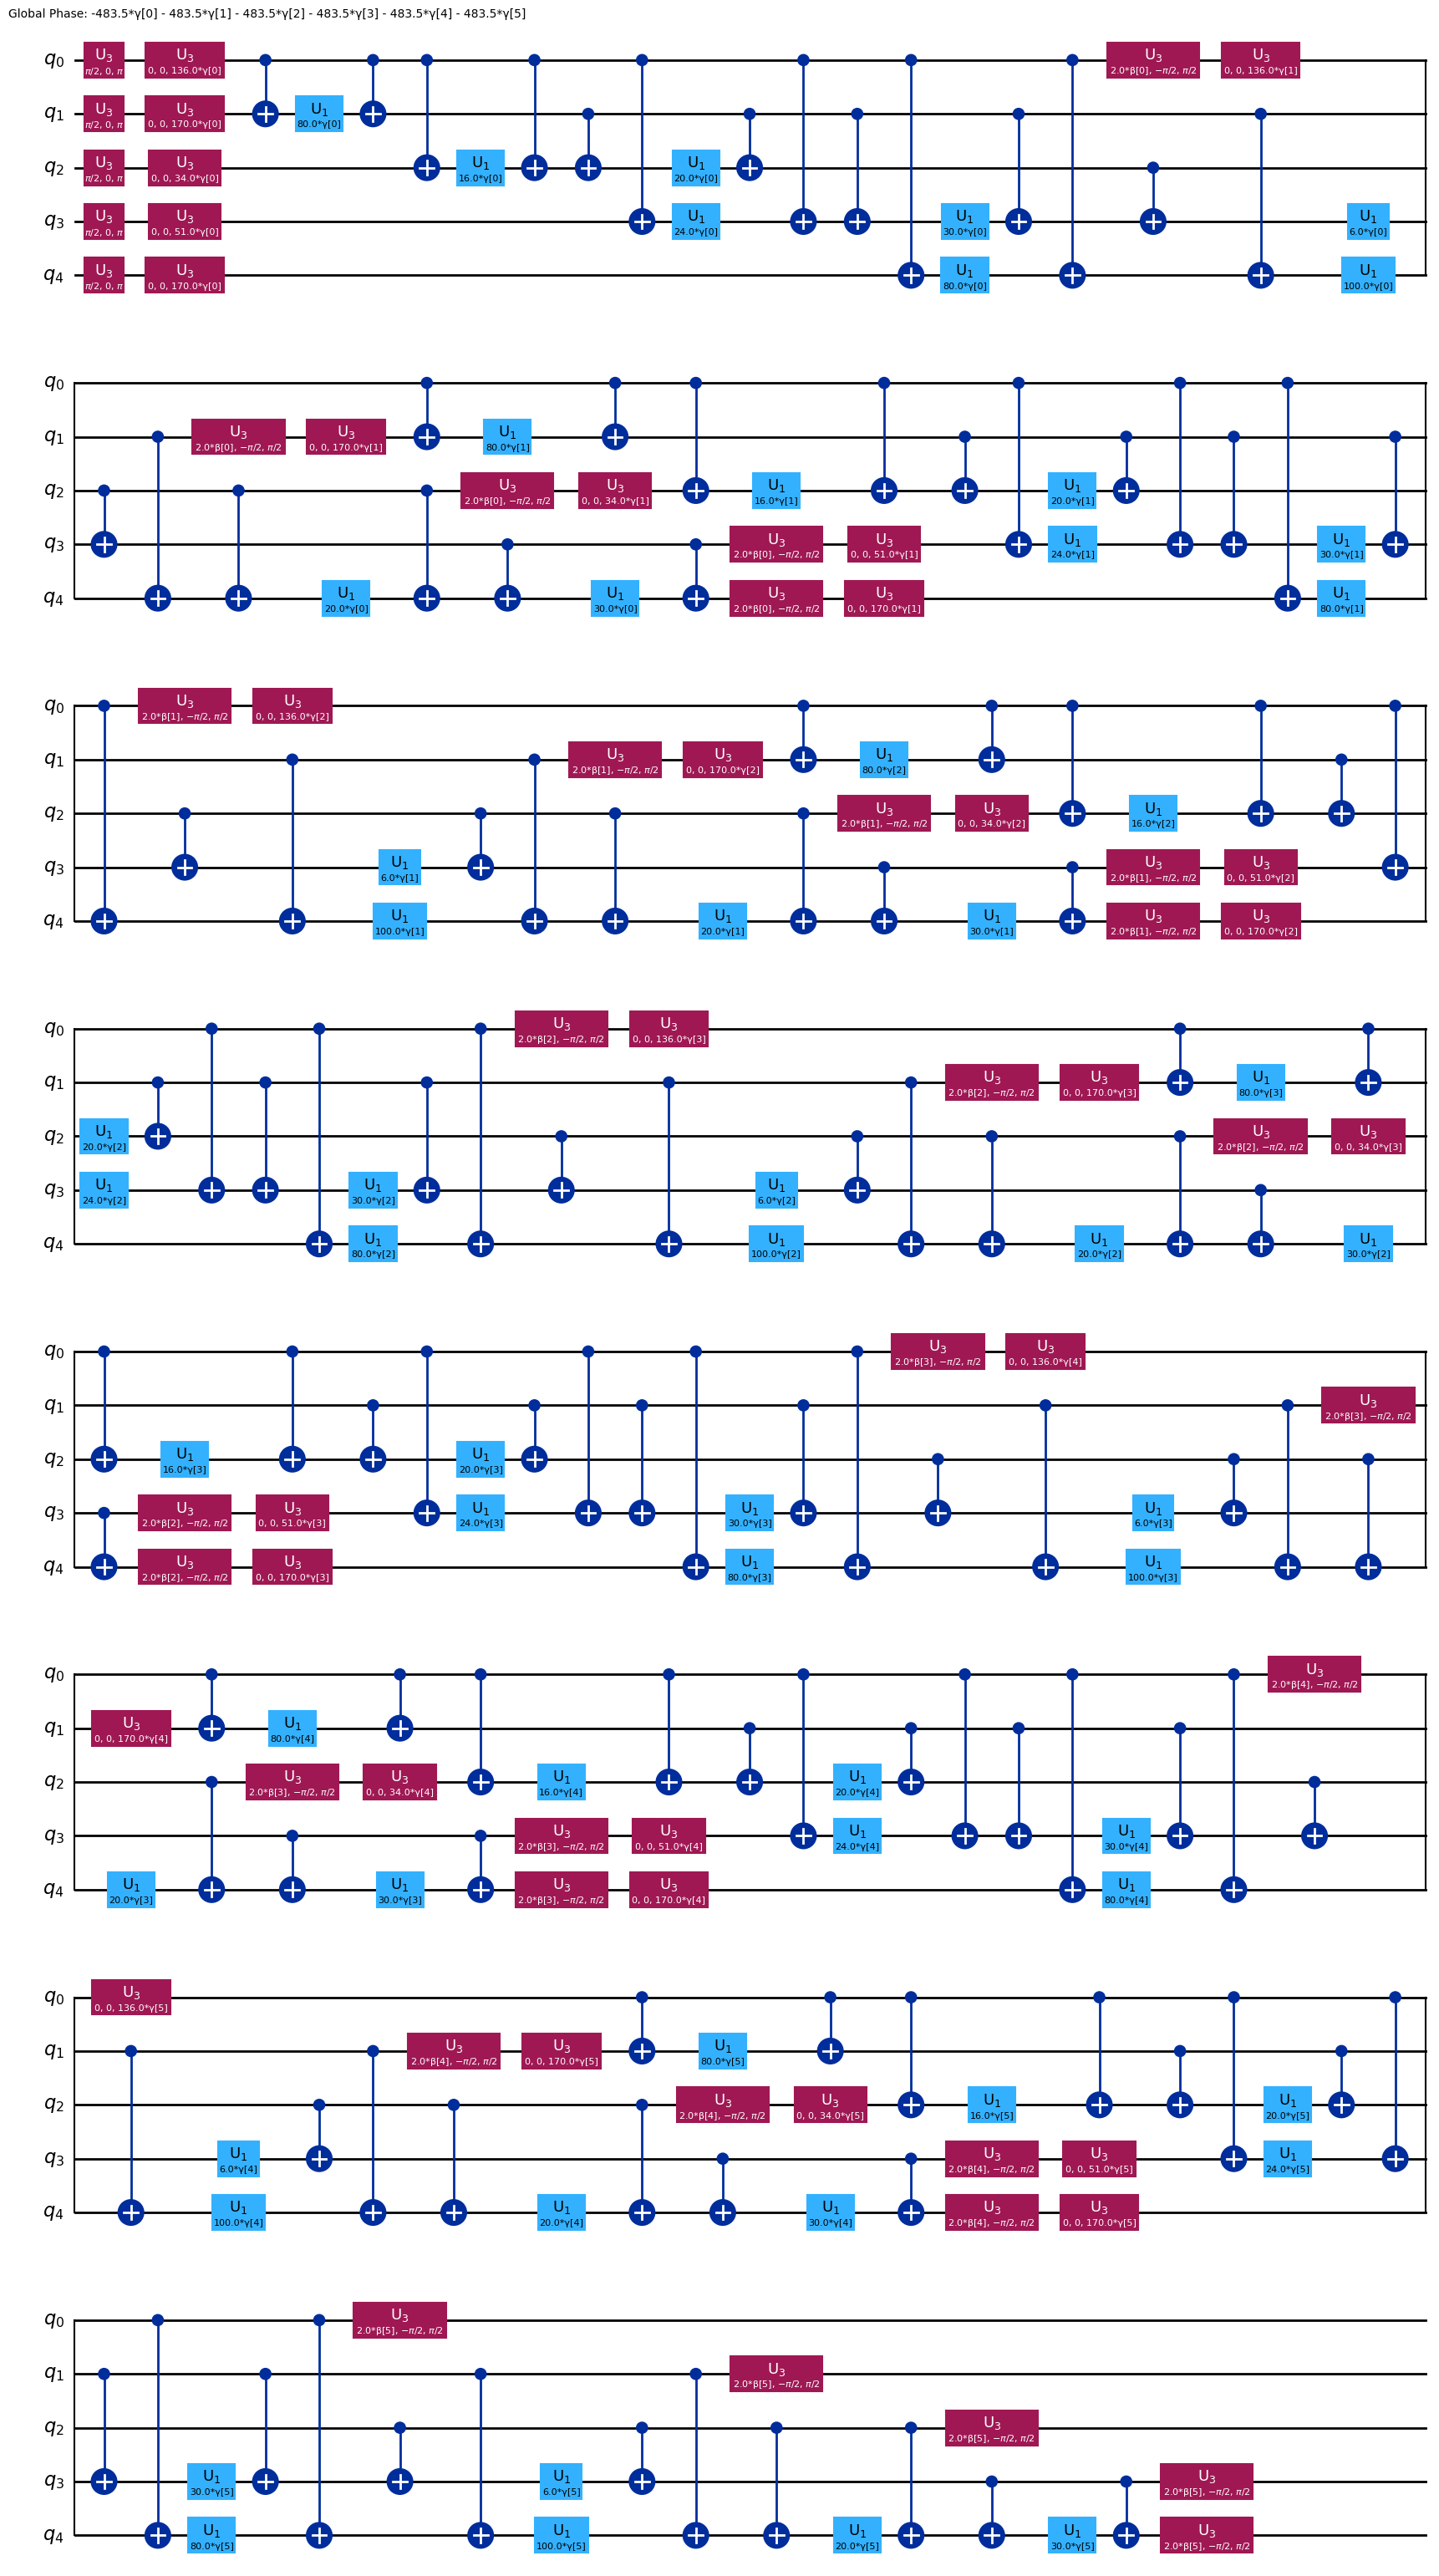

In [17]:
ansatz_isa.decompose(reps=2).draw(output="mpl", style="iqp")

In [18]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [19]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def run_experiment(n_range, p, shots_estimator, shots_sampler):
    ansatz = QAOAAnsatz(hamiltonian, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
    
    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator
    estimator.options.dynamical_decoupling.enable = True

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    sampler.options.dynamical_decoupling.enable = True

    x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

    results = [] 

    for n in range(n_range):
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
        ansatz_isa.decompose(reps=3).draw(output="mpl", style="iqp")

        qc = ansatz_isa.assign_parameters(res.x)
        qc.measure_all()
        qc_isa = pm.run(qc)

        # Running the circuit in the sampler
        result = sampler.run([qc_isa]).result()

        samp_dist = result[0].data.meas.get_counts()

        most_probable_state = max(samp_dist, key=samp_dist.get)
        results.append(most_probable_state)

    # Sort the states by probability and select the 15 most likely
    sorted_samp_dist = sorted(samp_dist.items(), key=lambda item: item[1], reverse=True)
    top_15_states = sorted_samp_dist[:15]

    # Calculate probabilities for the 15 states 
    total_samples = sum(samp_dist.values())
    top_states = [state for state, _ in top_15_states]
    top_probabilities = [count / total_samples for _, count in top_15_states]

    plt.figure(figsize=(12, 6))
    plt.bar(top_states, top_probabilities, color='purple', edgecolor='black')
    plt.xlabel("Quantum States")
    plt.ylabel("Probability")
    plt.title("Top 15 Most Probable States")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return results


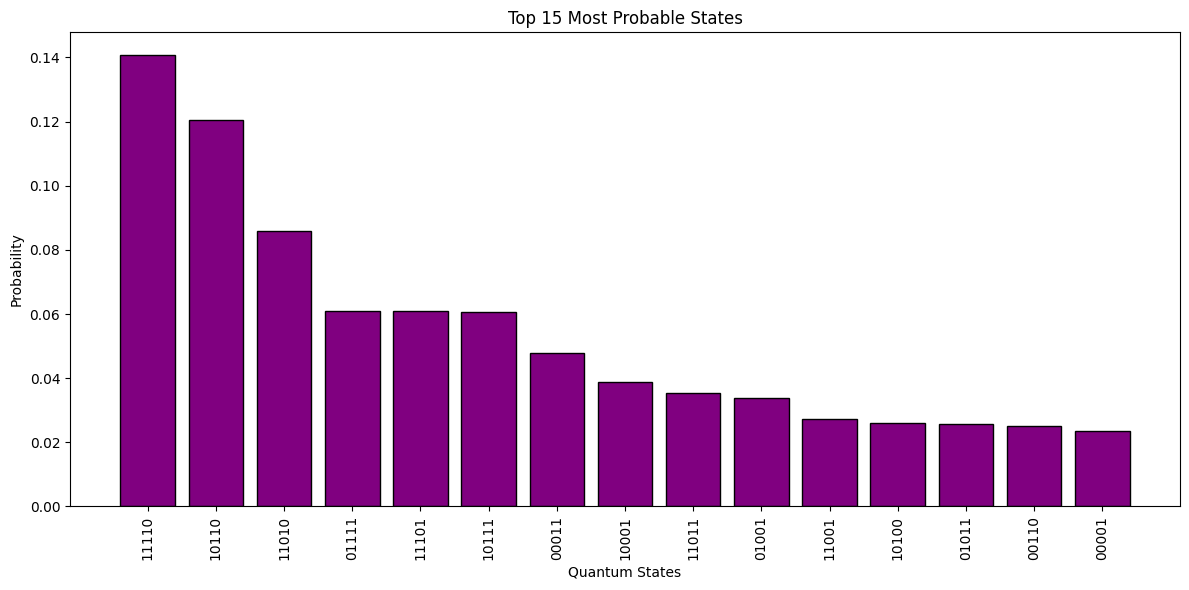

In [20]:
results = run_experiment(10, 6, 5000, 5000)

Estimator shots:  1000 
Samplere shots:  1000


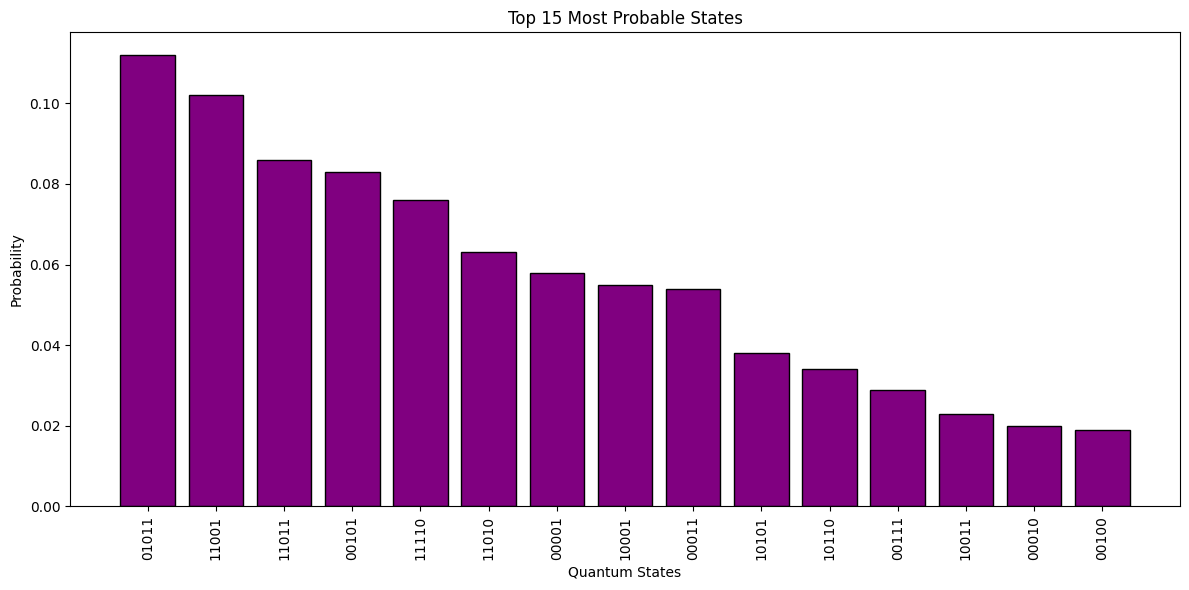

Estimator shots:  1000 
Samplere shots:  2000


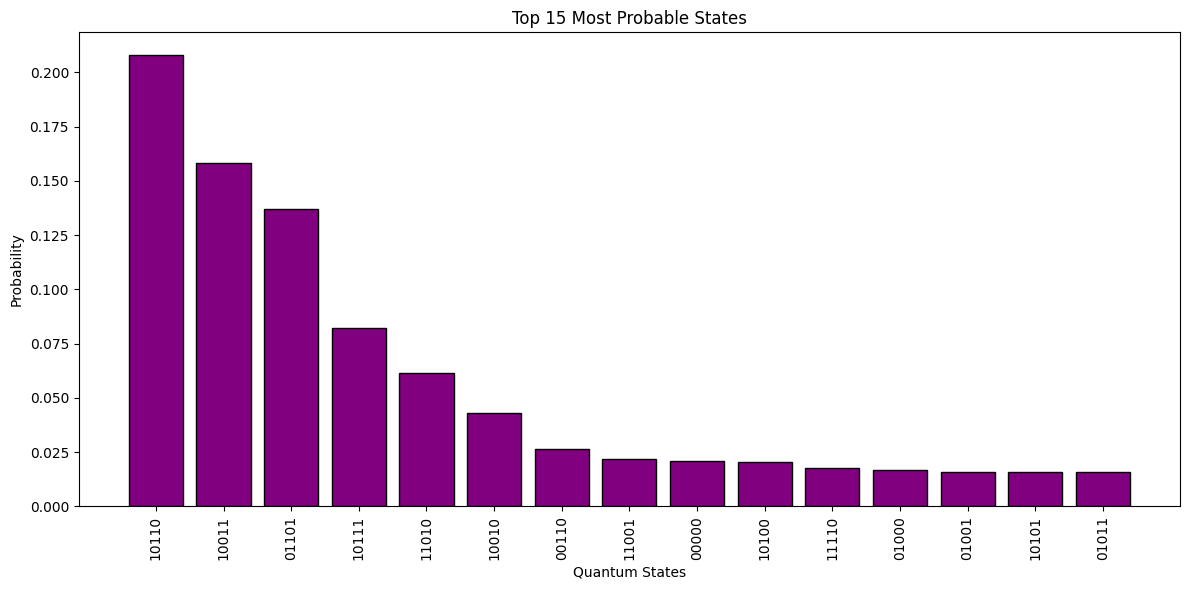

Estimator shots:  1000 
Samplere shots:  3000


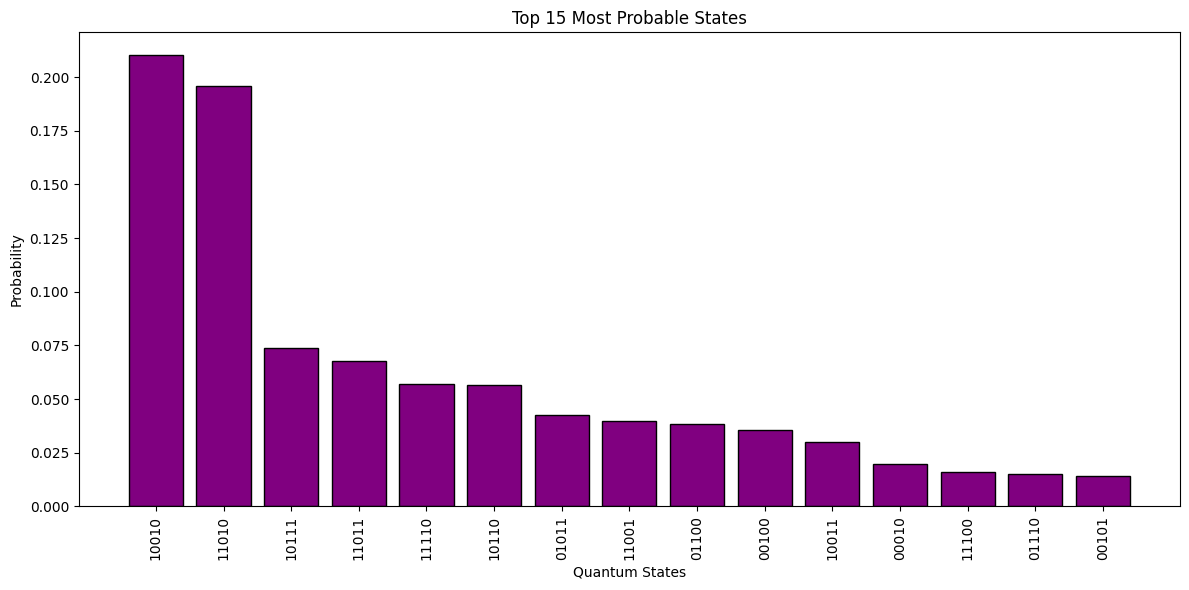

Estimator shots:  1000 
Samplere shots:  4000


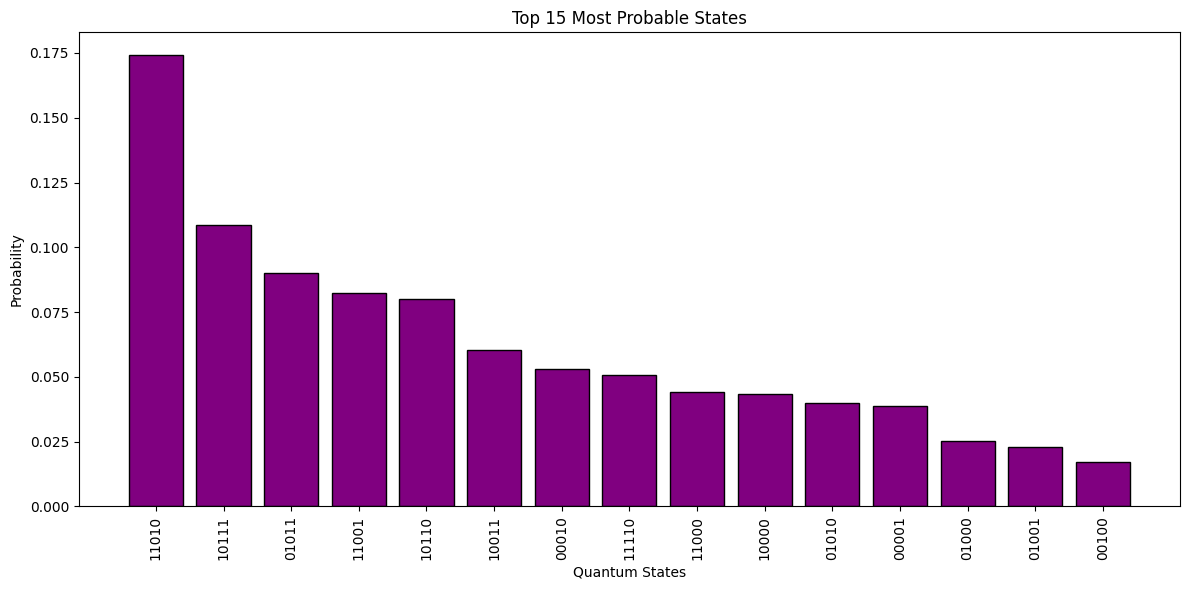

Estimator shots:  2000 
Samplere shots:  1000


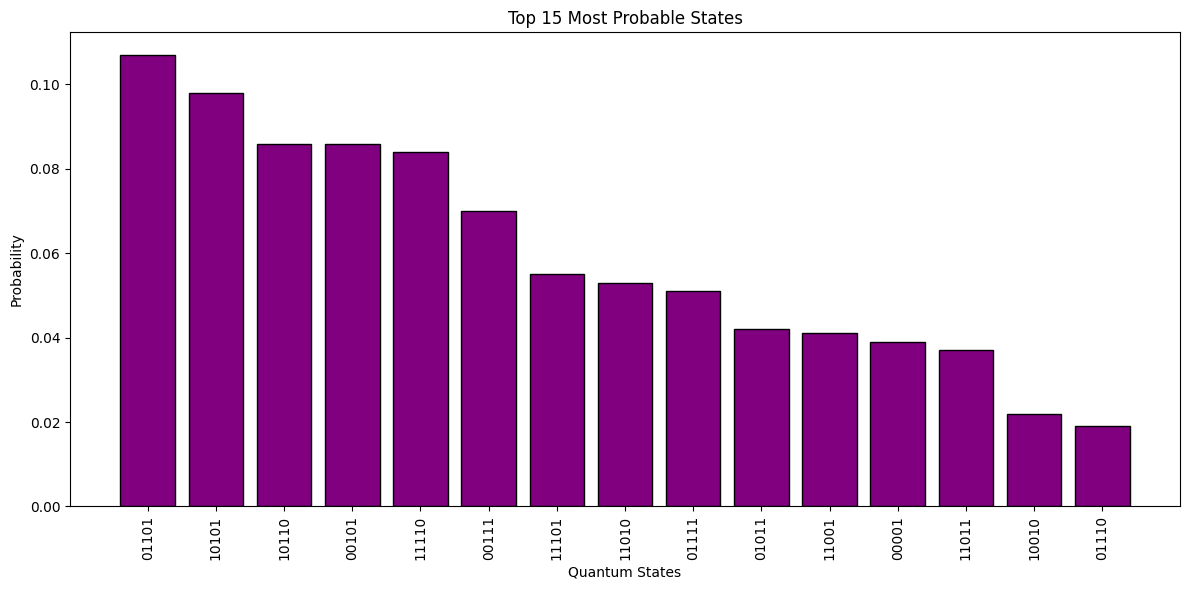

Estimator shots:  2000 
Samplere shots:  2000


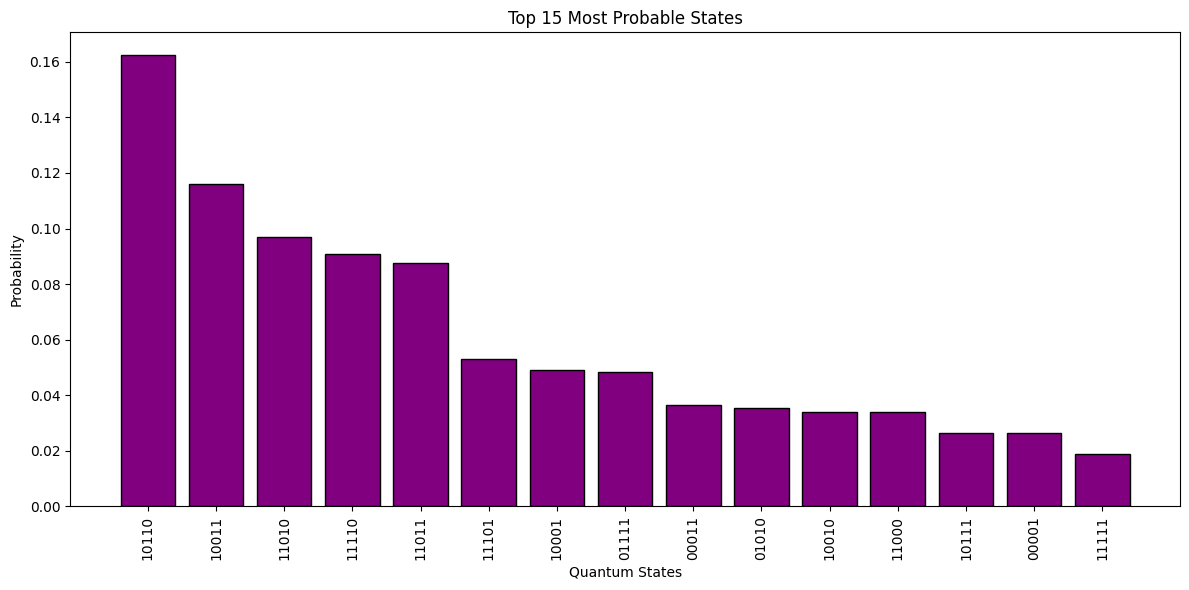

Estimator shots:  2000 
Samplere shots:  3000


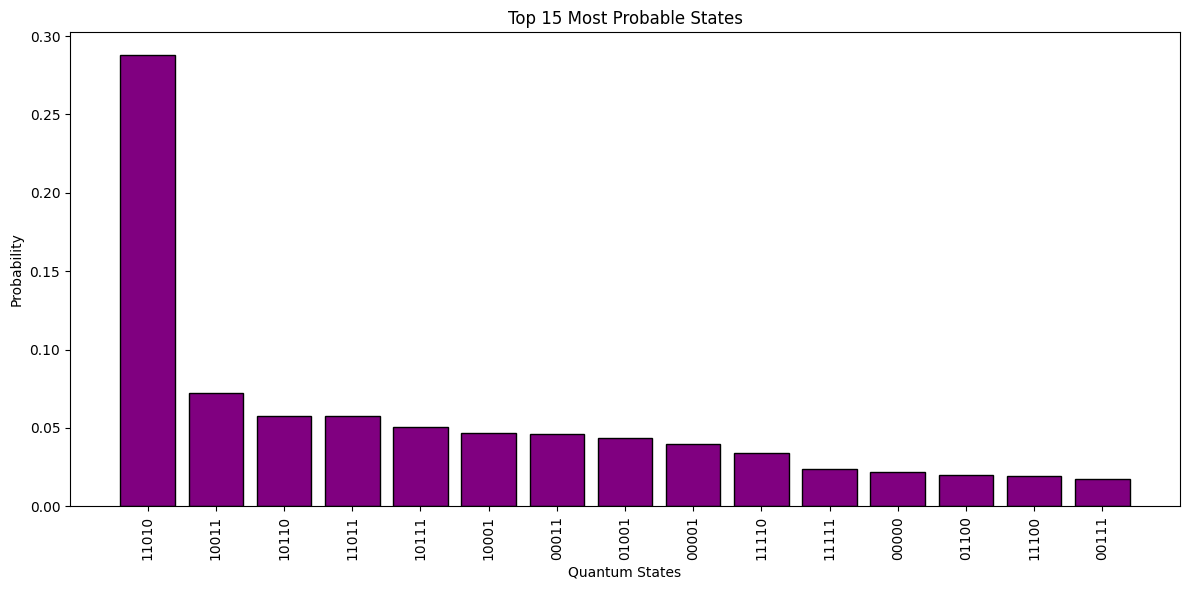

Estimator shots:  2000 
Samplere shots:  4000


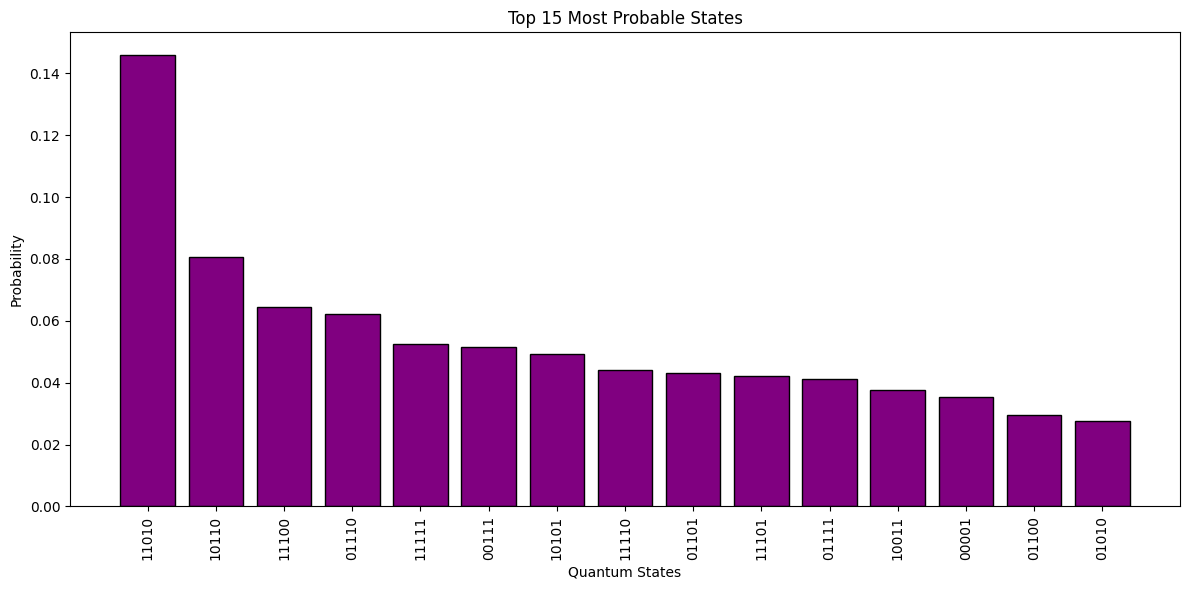

Estimator shots:  3000 
Samplere shots:  1000


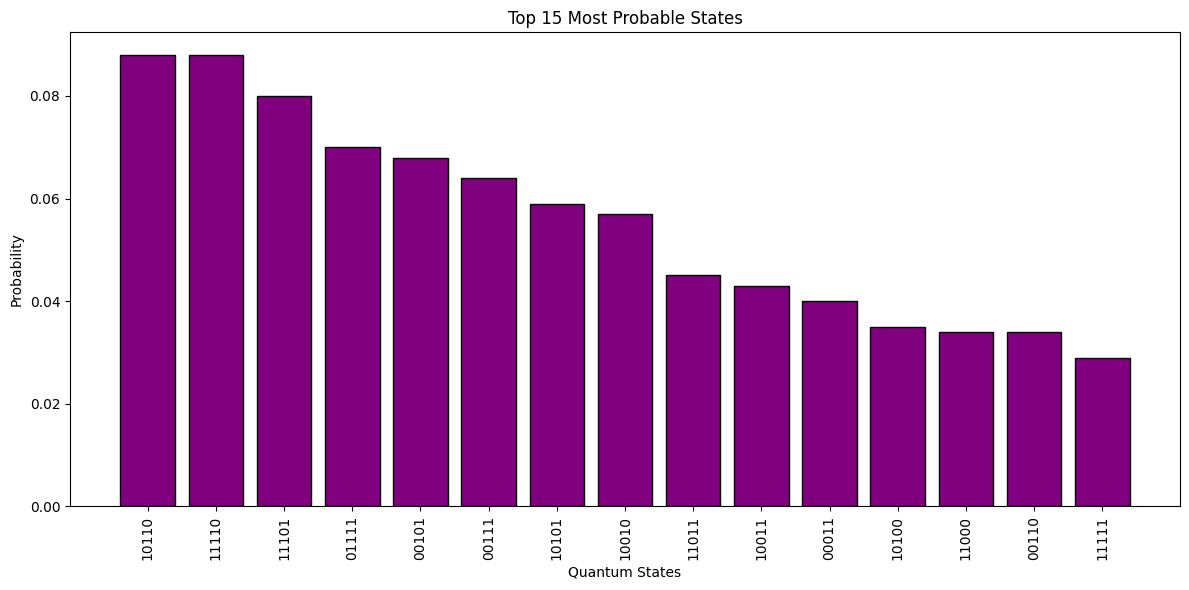

Estimator shots:  3000 
Samplere shots:  2000


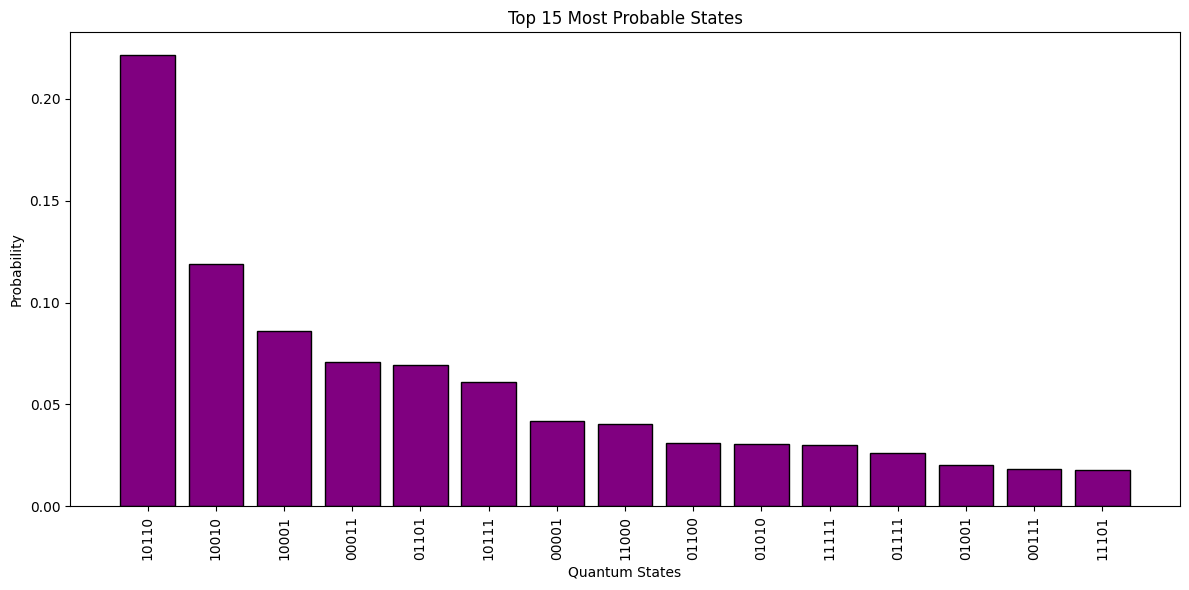

Estimator shots:  3000 
Samplere shots:  3000


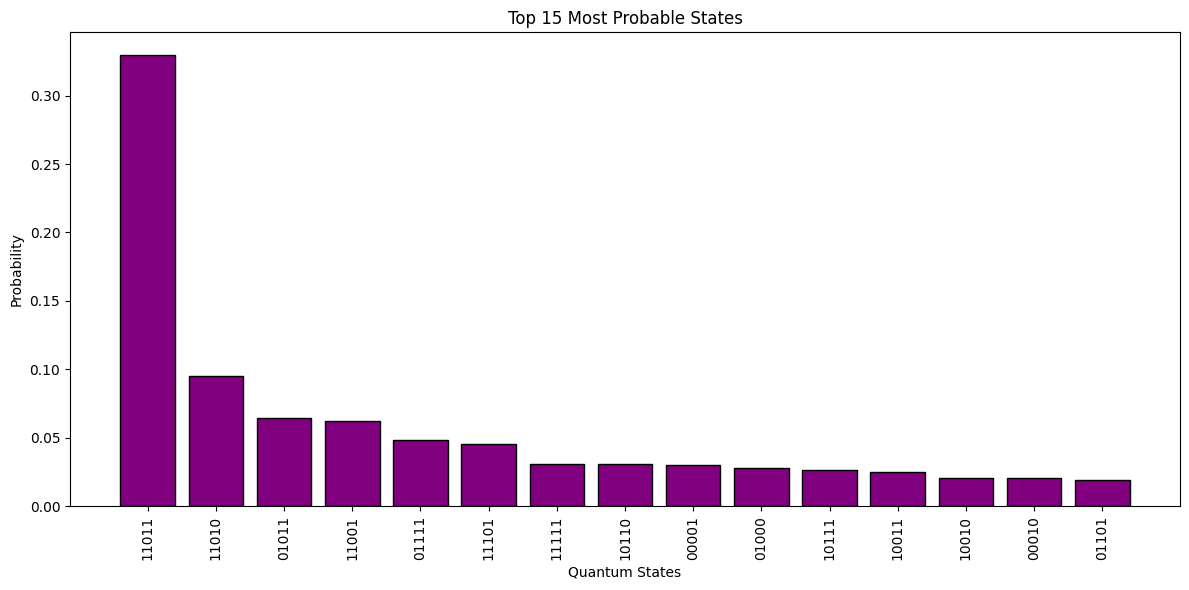

Estimator shots:  3000 
Samplere shots:  4000


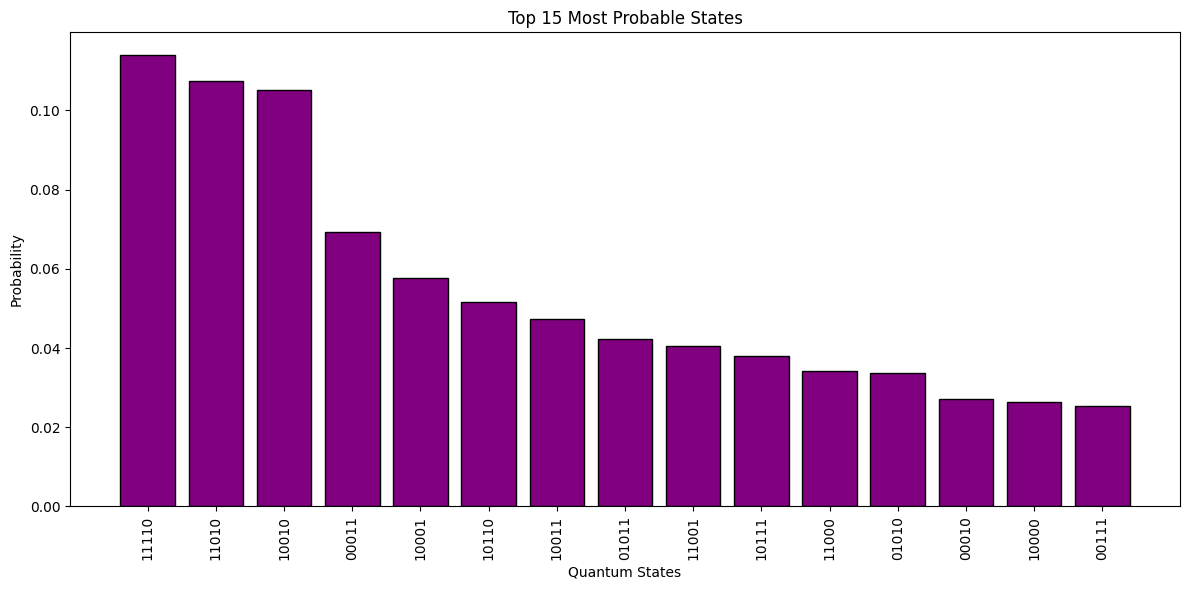

Estimator shots:  4000 
Samplere shots:  1000


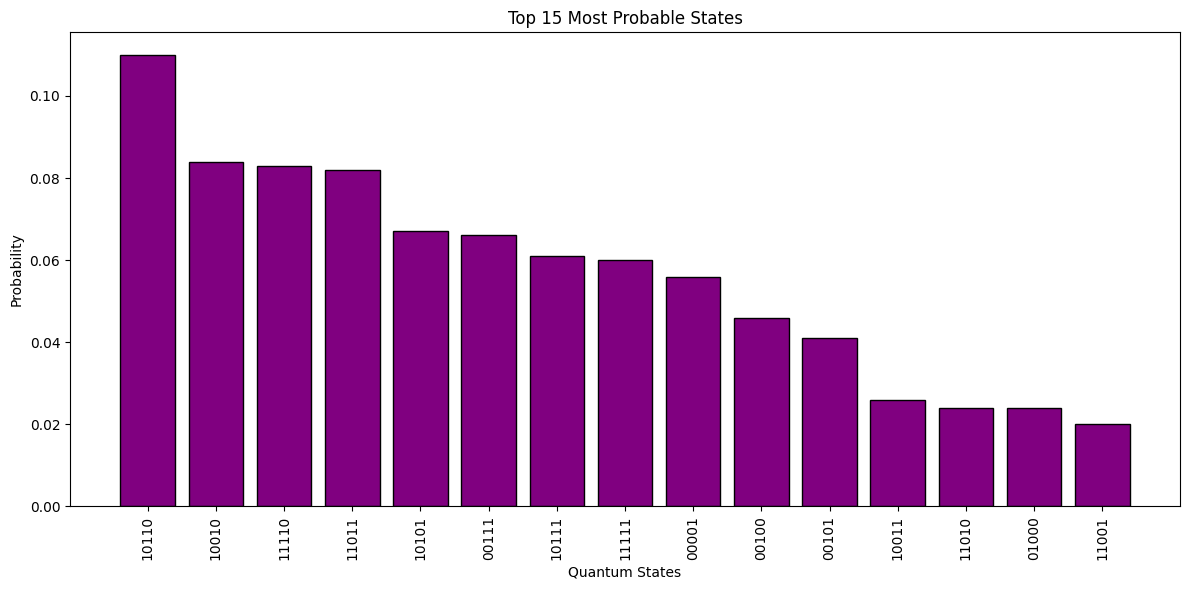

Estimator shots:  4000 
Samplere shots:  2000


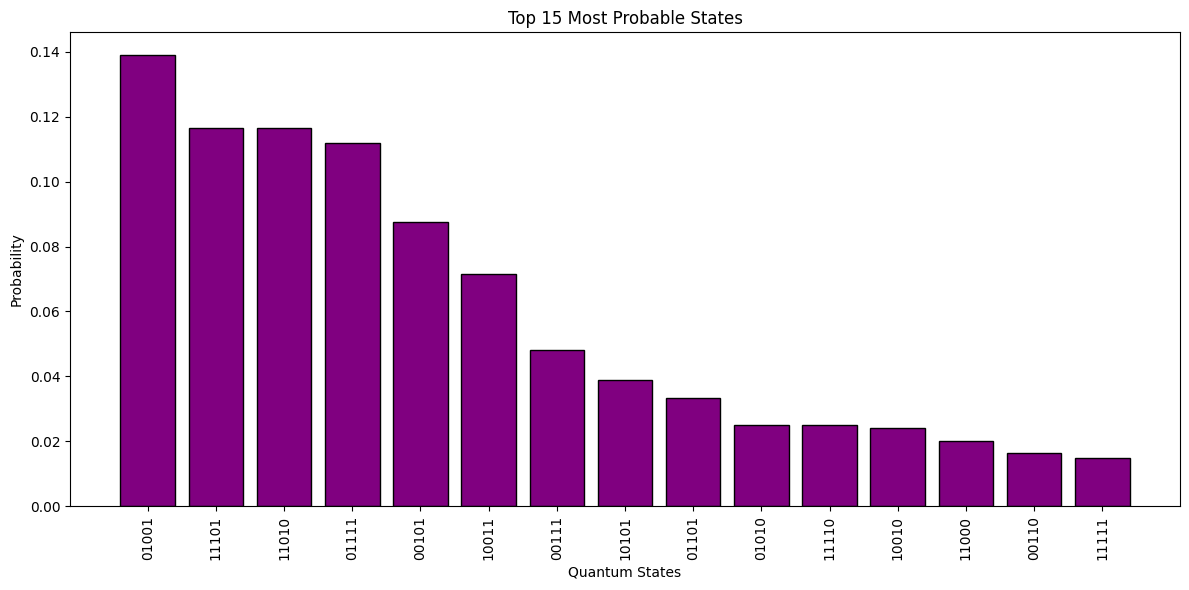

Estimator shots:  4000 
Samplere shots:  3000


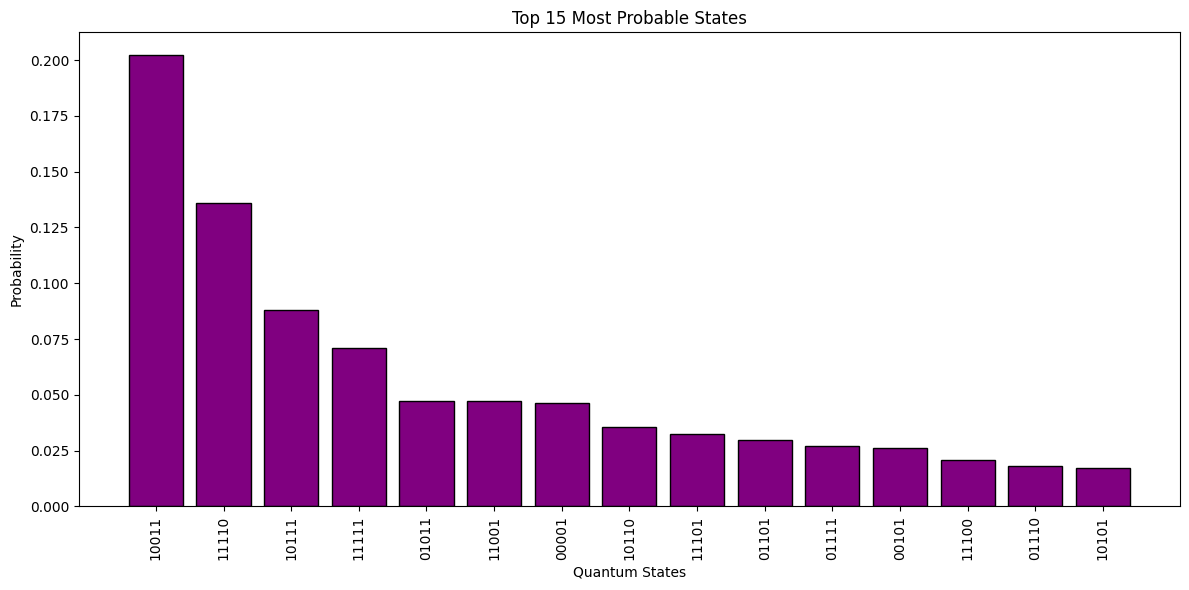

Estimator shots:  4000 
Samplere shots:  4000


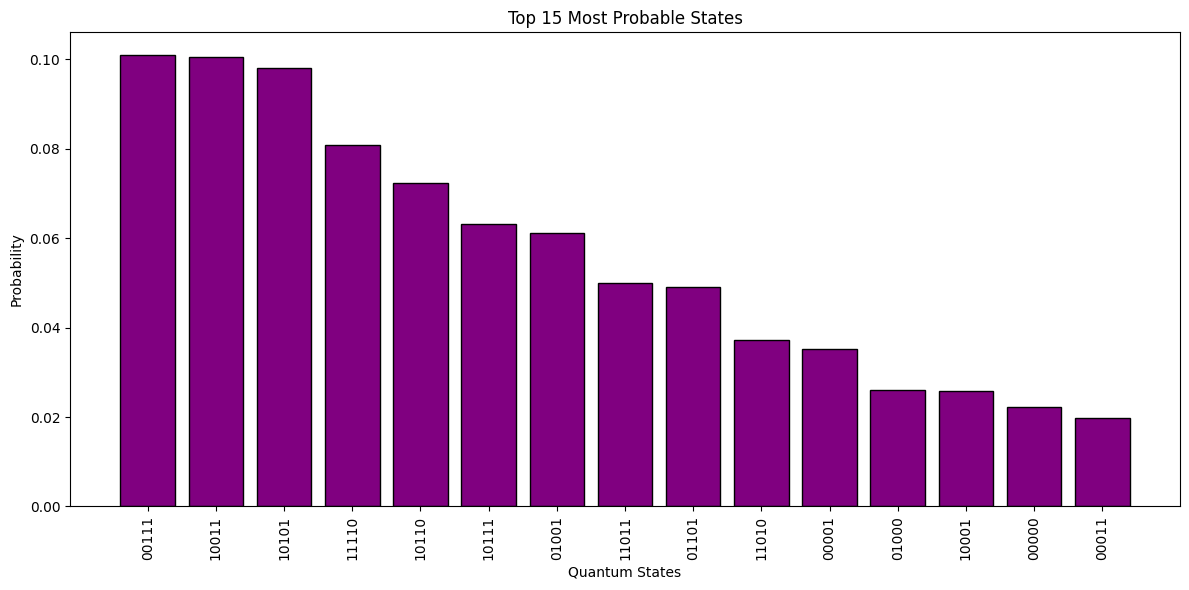

In [21]:
# Loop for different shots values
for i in range(1000, 5000, 1000):
    for j in range(1000, 5000, 1000):
        print("Estimator shots: ", i, "\nSamplere shots: ", j)
        run_experiment(10, 4, i, j)

In [22]:
values = {'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 0}
qubo.objective.evaluate([values[f'x{i}'] for i in range(1, 6)])

4.0

In [23]:
best_values = {'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 0}
worst_values_feasible = {'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 0}
worst_values = {'x1': 1, 'x2': 0, 'x3': 1, 'x4': 1, 'x5': 1}

f_max = qubo.objective.evaluate([best_values[f'x{i}'] for i in range(1, 6)])
f_min = qubo.objective.evaluate([worst_values_feasible[f'x{i}'] for i in range(1, 6)])
f_min2 = qubo.objective.evaluate([worst_values[f'x{i}'] for i in range(1, 6)])

f_max, f_min, f_min2

(4.0, 625.0, 4.0)

In [24]:
def r(z):
    return (qubo.objective.evaluate(z) - f_max) / (f_min - f_max)

In [25]:
r([best_values[f'x{i}'] for i in range(1, 6)]), r([worst_values_feasible[f'x{i}'] for i in range(1, 6)]), r([worst_values[f'x{i}'] for i in range(1, 6)])

(0.0, 1.0, 0.0)

In [26]:
def run_experiment_performance_measurement(n_range, p, shots_estimator, shots_sampler, level):
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=level)

    ansatz = QAOAAnsatz(hamiltonian, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    
    results_x = []
    
    for i in range(n_range):
        x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
        ansatz_isa.decompose(reps=3).draw(output="mpl", style="iqp")
        results_x.append(res.x)
    results_x_mean = np.mean(results_x, axis=0)

    qc = ansatz.assign_parameters(results_x_mean)
    qc.measure_all()
    qc_isa = pm.run(qc)

    result = sampler.run([qc_isa]).result()
    variables = [list(map(int, key)) for key in result[0].data.meas.get_counts().keys()]

    approx_ratios = []
    for z in variables:
        approx_ratios.append(r(z))
    
    min_ratio = min(approx_ratios)
    min_ratio_z = variables[approx_ratios.index(min_ratio)]

    # Print the results
    print("Minimal approximation ratio:", min_ratio)
    print("Corresponding x array (z):", min_ratio_z)

    return min_ratio, min_ratio_z

In [27]:
run_experiment_performance_measurement(20, 3, 10, 10, 1)

Minimal approximation ratio: 0.0
Corresponding x array (z): [1, 1, 1, 1, 0]
